In [1]:
import glob
import pandas as pd
import os
import psycopg2
from psycopg2 import sql
    
    


### Database connection to import the data from postgresDB

In [2]:
db_connection = psycopg2.connect(host="localhost", database="postgres", user="postgres",
                                             password="password")
db_cursor = db_connection.cursor()
print('Successfully connected to DB for hist')
select_file_names_query = """select * from public.eec_test """
db_cursor.execute(select_file_names_query)
#df = pd.DataFrame(db_cursor.fetchall())
#df.columns = db_cursor.column_names

tupples = db_cursor.fetchall()
db_cursor.close()
column_names= [desc[0] for desc in db_cursor.description]
#print(column_names)
# We just need to turn it into a pandas dataframe
df = pd.DataFrame(tupples, columns=column_names)

Successfully connected to DB for hist


In [3]:
df.columns.values

array(['stopid', 'test', 'test_step', 'wheel', 'odocount', 'dir',
       'startmean', 'endmean', 'stoptime', 'p1_start', 'p1_end',
       'p1_meant', 'p1_max', 'p1_min', 'trot1_start', 'trot1_end',
       'trot1_meant', 'trot2_start', 'trot2_end', 'v1_start', 'v1_end',
       'dec_meant', 'dec_max', 'strangle_start', 'strangle_end',
       'strangle_meant', 'tamb1_start', 'rh1_start', 'noise_search',
       'gpslat_start', 'gpslong_start', 'f_1', 'd_1', 'l_1', 'af_1',
       'al_1', 'time1_start', 'time1_end', 'f_2', 'd_2', 'l_2', 'af_2',
       'al_2', 'time2_start', 'time2_end', 'f_3', 'd_3', 'l_3', 'af_3',
       'al_3', 'time3_start', 'time3_end', 'f_4', 'd_4', 'l_4', 'af_4',
       'al_4', 'time4_start', 'time4_end', 'f_5', 'd_5', 'l_5', 'af_5',
       'al_5', 'time5_start', 'time5_end', 'f_6', 'd_6', 'l_6', 'af_6',
       'al_6', 'time6_start', 'time6_end', 'f_7', 'd_7', 'l_7', 'af_7',
       'al_7', 'time7_start', 'time7_end', 'f_8', 'd_8', 'l_8', 'af_8',
       'al_8', 'time8_s

In [4]:
df=df[[
        'stopid','stoptime', 'wheel','startmean', 'endmean', 
       'p1_meant', 'p1_max',  
       'trot1_meant', 'v1_start', 'v1_end',
         'tamb1_start']]
df=df.dropna()
df=df[df['wheel'] == 'fl']
df.head()

,stopid,stoptime,wheel,startmean,endmean,p1_meant,p1_max,trot1_meant,v1_start,v1_end,tamb1_start
0,1,10,fl,10:31:47,10:31:57,26.8,40.8,46.0,0.0,0.0,9.0
1,2,1,fl,10:31:59,10:32:00,9.1,11.4,46.0,3.4,0.4,9.0
2,3,1,fl,10:32:09,10:32:11,3.9,5.7,46.0,6.8,3.2,9.0
3,4,3,fl,10:32:11,10:32:14,1.6,4.5,46.0,4.2,4.3,9.0
4,5,1,fl,10:32:17,10:32:17,5.2,5.7,46.0,13.9,13.4,9.0


In [5]:
import numpy as np

df['startmean'] =  pd.to_datetime(df['startmean'], format='%H:%M:%S')
df['endmean'] =  pd.to_datetime(df['endmean'], format='%H:%M:%S')
df['duration']=(df['startmean'] - df['endmean'].shift(1))/ np.timedelta64(1, 's')

df['duration']=df['duration'].fillna(0).astype('int64')
df['prev_trot1_meant']=df['trot1_meant'].shift(1).fillna(0)

In [6]:
df.head(10)

,stopid,stoptime,wheel,startmean,endmean,p1_meant,p1_max,trot1_meant,v1_start,v1_end,tamb1_start,duration,prev_trot1_meant
0,1,10,fl,1900-01-01 10:31:47,1900-01-01 10:31:57,26.8,40.8,46.0,0.0,0.0,9.0,0,0.0
1,2,1,fl,1900-01-01 10:31:59,1900-01-01 10:32:00,9.1,11.4,46.0,3.4,0.4,9.0,2,46.0
2,3,1,fl,1900-01-01 10:32:09,1900-01-01 10:32:11,3.9,5.7,46.0,6.8,3.2,9.0,9,46.0
3,4,3,fl,1900-01-01 10:32:11,1900-01-01 10:32:14,1.6,4.5,46.0,4.2,4.3,9.0,0,46.0
4,5,1,fl,1900-01-01 10:32:17,1900-01-01 10:32:17,5.2,5.7,46.0,13.9,13.4,9.0,3,46.0
5,6,5,fl,1900-01-01 10:32:23,1900-01-01 10:32:28,5.1,9.3,48.0,17.6,5.0,9.0,6,46.0
6,7,4,fl,1900-01-01 10:32:48,1900-01-01 10:32:52,12.8,17.1,54.0,37.3,7.6,9.0,20,48.0
7,8,36,fl,1900-01-01 10:32:52,1900-01-01 10:33:28,14.4,16.5,57.0,7.1,0.0,9.0,0,54.0
8,9,2,fl,1900-01-01 10:33:56,1900-01-01 10:33:58,3.7,3.9,55.0,59.5,52.6,9.0,28,57.0
9,10,2,fl,1900-01-01 10:34:26,1900-01-01 10:34:28,7.9,10.2,56.0,36.5,29.6,9.0,28,55.0


In [7]:
df['stoptime'] = df['stoptime'].astype(float)
df['duration'] = df['duration'].astype(float)

In [8]:
df.dtypes

stopid                       int64
stoptime                   float64
wheel                       object
startmean           datetime64[ns]
endmean             datetime64[ns]
p1_meant                   float64
p1_max                     float64
trot1_meant                float64
v1_start                   float64
v1_end                     float64
tamb1_start                float64
duration                   float64
prev_trot1_meant           float64
dtype: object

In [9]:
df_final=df[[
        'stopid','stoptime', 
       'p1_meant', 'p1_max', 'prev_trot1_meant', 
        'v1_start', 'v1_end',
         'tamb1_start','duration','trot1_meant']]

In [10]:
df_final.head()

,stopid,stoptime,p1_meant,p1_max,prev_trot1_meant,v1_start,v1_end,tamb1_start,duration,trot1_meant
0,1,10.0,26.8,40.8,0.0,0.0,0.0,9.0,0.0,46.0
1,2,1.0,9.1,11.4,46.0,3.4,0.4,9.0,2.0,46.0
2,3,1.0,3.9,5.7,46.0,6.8,3.2,9.0,9.0,46.0
3,4,3.0,1.6,4.5,46.0,4.2,4.3,9.0,0.0,46.0
4,5,1.0,5.2,5.7,46.0,13.9,13.4,9.0,3.0,46.0


In [11]:
print(df_final['trot1_meant'].value_counts())

1372.0    47
123.0     30
133.0     26
122.0     25
138.0     24
          ..
48.0       1
396.0      1
809.0      1
55.0       1
54.0       1
Name: trot1_meant, Length: 133, dtype: int64


### outlier detection and remove using inter quartile range

In [12]:
def find_outliers_tukey(x):
    q1=np.percentile(x,25)
    q3=np.percentile(x,75)
    iqr=q3-q1
    floor=q1-1.5*iqr
    ceiling=q3+1.5*iqr
    outlier_indices=list(x.index[(x<floor)|(x>ceiling)])
    outliers_values=list(x[outlier_indices])
    
    return outlier_indices,outliers_values
    

In [13]:
tukey_indices,tukey_values=find_outliers_tukey(df_final['trot1_meant'])
print(np.sort(tukey_indices))

[  0   1   2   3   4   5   6   7   8   9  10  14  60  61  62  63  64  65
 289 290 291 292 293 294 295 296 413 414 415 416 417 418 419 420 421 433
 434 435 436 437 488 489 490 491 492 493 494 495 496 497 551 573 574 575
 576 577 578 579 580 581 582 794 795 796 797 798]


In [14]:
df_final2 = df_final.drop([0  , 1  , 2 ,  3   ,4  , 5  , 6 ,  7  , 8  , 9  ,10 , 14 ,15 ,60  ,61 , 62 , 63 , 64 , 65,
 289,290 ,291 ,292 ,293 ,294 ,295, 296 ,413 ,414 ,415 ,416 ,417 ,418 ,419 ,420 ,421 ,433,
 434 ,435, 436 ,437, 488, 489 ,490 ,491 ,492, 493 ,494 ,495 ,496 ,497 ,551 ,573 ,574 ,575,
 576 ,577 ,578 ,579 ,580 ,581 ,582 ,794 ,795 ,796 ,797 ,798])

In [15]:
df_final2.reset_index().head(20)

,index,stopid,stoptime,p1_meant,p1_max,prev_trot1_meant,v1_start,v1_end,tamb1_start,duration,trot1_meant
0,11,12,49.0,17.9,22.5,60.0,32.3,0.0,10.0,4.0,69.0
1,12,13,2.0,9.0,11.4,69.0,0.0,0.0,10.0,1.0,68.0
2,13,14,2.0,7.6,10.5,68.0,30.0,25.2,10.0,11.0,68.0
3,16,17,0.0,1.6,2.4,73.0,33.3,33.0,10.0,9.0,73.0
4,17,18,1.0,7.0,7.8,73.0,39.1,31.9,10.0,4.0,73.0
5,18,19,1.0,2.2,2.4,73.0,24.5,22.8,10.0,5.0,73.0
6,19,20,7.0,9.2,21.3,73.0,50.3,21.7,12.0,59.0,71.0
7,20,21,2.0,3.5,6.3,71.0,25.0,20.5,12.0,3.0,76.0
8,21,22,1.0,2.0,3.3,76.0,40.3,39.6,12.0,8.0,75.0
9,22,23,4.0,9.4,13.2,75.0,46.8,29.8,12.0,12.0,77.0


In [16]:
df_final2['prev_trot1_meant'].mean()

137.96852046169988

In [17]:
df_final2.describe()

,stopid,stoptime,p1_meant,p1_max,prev_trot1_meant,v1_start,v1_end,tamb1_start,duration,trot1_meant
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.00000,953.000000,953.000000,953.000000
mean,521.180483,4.497377,7.806611,11.186254,137.968520,27.880273,19.87681,14.646380,7.523610,130.383001
std,295.081225,7.462810,5.972374,8.314021,94.636706,23.304824,22.39947,2.085824,10.759778,26.691893
min,12.000000,0.000000,0.000000,0.000000,60.000000,-10.000000,-1.10000,9.000000,0.000000,68.000000
25%,258.000000,1.000000,3.600000,5.400000,117.000000,4.500000,0.00000,13.000000,1.000000,117.000000
50%,528.000000,2.000000,6.500000,9.300000,132.000000,26.100000,12.90000,15.000000,4.000000,132.000000
75%,777.000000,4.000000,10.100000,15.000000,147.000000,43.300000,34.30000,16.000000,9.000000,147.000000
max,1020.000000,69.000000,34.300000,57.600000,1372.000000,97.700000,92.50000,20.000000,112.000000,190.000000


In [18]:
df_final2.corr()

,stopid,stoptime,p1_meant,p1_max,prev_trot1_meant,v1_start,v1_end,tamb1_start,duration,trot1_meant
stopid,1.000000,-0.008300,-0.058514,-0.067308,-0.060524,0.007755,0.022311,0.894329,0.081265,-0.134632
stoptime,-0.008300,1.000000,0.484418,0.418973,-0.009047,-0.124987,-0.334740,-0.016289,-0.034276,0.063013
p1_meant,-0.058514,0.484418,1.000000,0.956023,0.030128,-0.220796,-0.393761,-0.023279,0.078839,0.132792
p1_max,-0.067308,0.418973,0.956023,1.000000,0.024222,-0.177138,-0.381454,-0.028204,0.090037,0.143814
prev_trot1_meant,-0.060524,-0.009047,0.030128,0.024222,1.000000,-0.016903,-0.047260,0.000103,-0.005747,0.292463
v1_start,0.007755,-0.124987,-0.220796,-0.177138,-0.016903,1.000000,0.871937,-0.073859,0.375714,-0.120753
v1_end,0.022311,-0.334740,-0.393761,-0.381454,-0.047260,0.871937,1.000000,-0.069737,0.352398,-0.179645
tamb1_start,0.894329,-0.016289,-0.023279,-0.028204,0.000103,-0.073859,-0.069737,1.000000,0.066342,-0.012809
duration,0.081265,-0.034276,0.078839,0.090037,-0.005747,0.375714,0.352398,0.066342,1.000000,-0.179886
trot1_meant,-0.134632,0.063013,0.132792,0.143814,0.292463,-0.120753,-0.179645,-0.012809,-0.179886,1.000000


Text(0.5, 1.0, 'Seaborn')

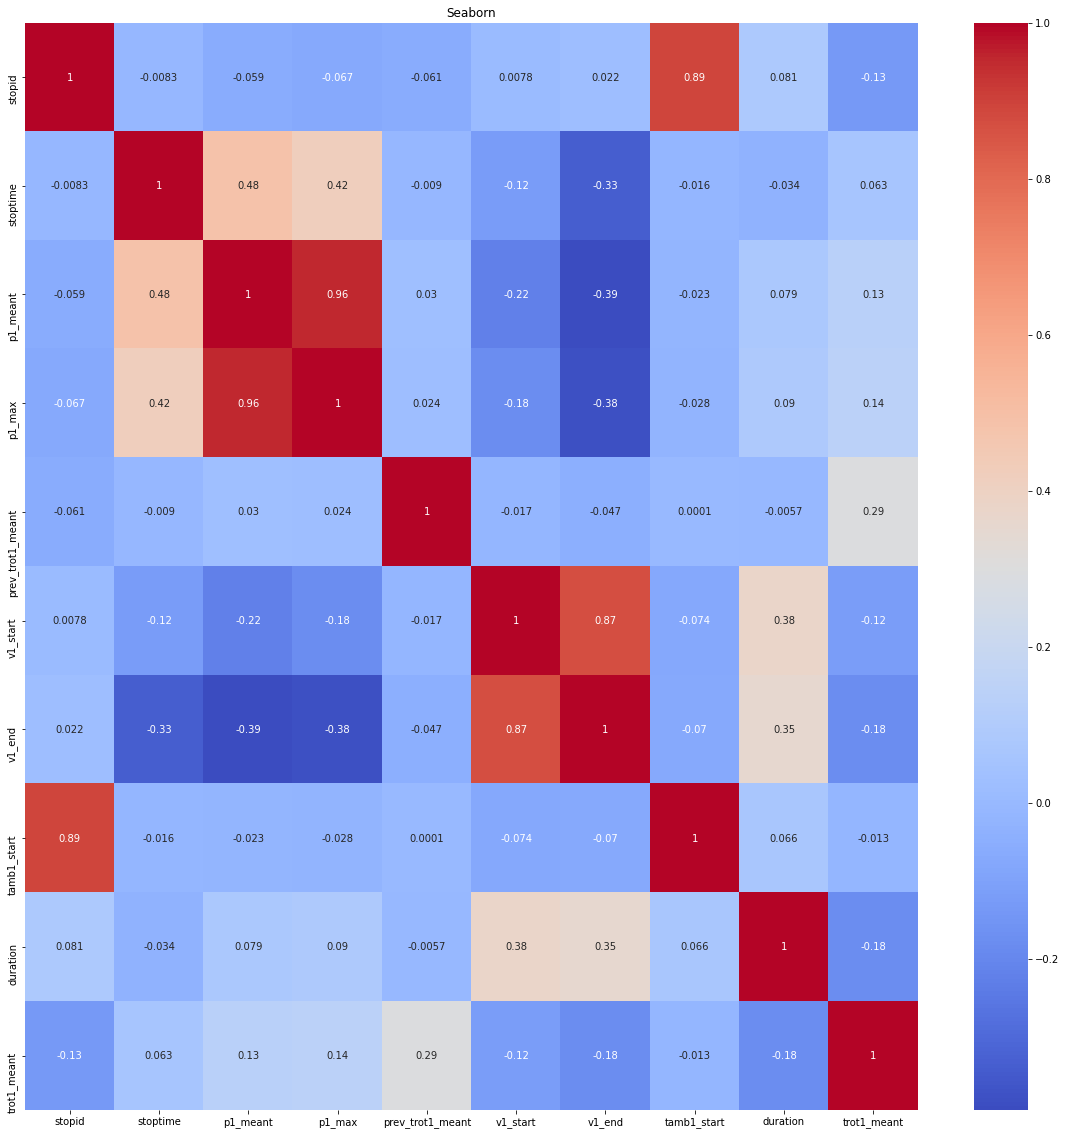

In [19]:
import seaborn 
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,20))
seaborn.heatmap(df_final2.corr(), annot=True, cmap="coolwarm").set_title('Seaborn')

C:\Users\zahid\anaconda3\envs\tensorflow-sessions\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


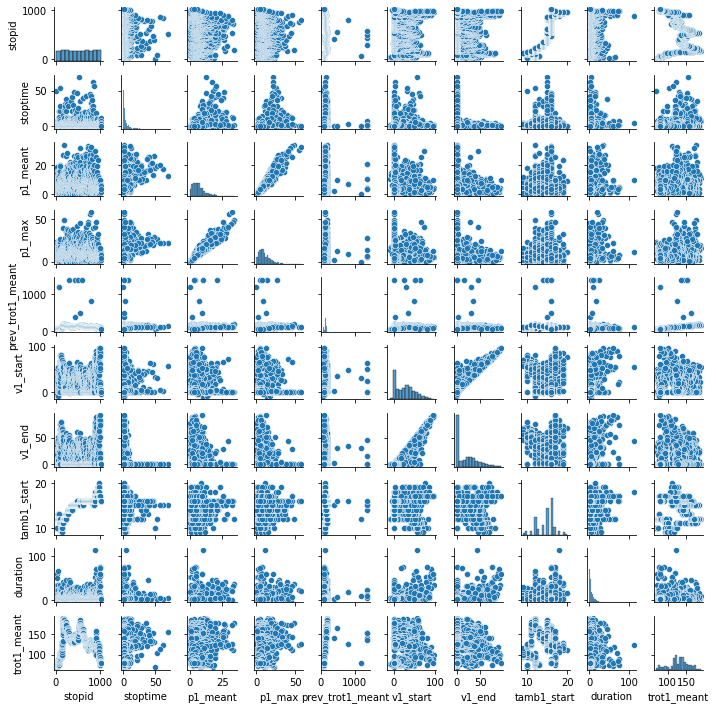

In [20]:
seaborn.pairplot(df_final2, size=1);

## spliting training and test data for prediction

In [50]:
from sklearn.model_selection import train_test_split

X=df_final2[['stopid','stoptime', 
       'p1_meant', 'p1_max', 'prev_trot1_meant', 
        'v1_start', 'v1_end',
         'tamb1_start','duration']]
y=df_final2[['trot1_meant']]


x_train, x_test,y_train,y_test = train_test_split(X,y,test_size =0.2,random_state = 10)
x_test.reset_index(drop=True, inplace=True)
X2=X[1::]
y2=y[1::]
X.reset_index(drop=True,inplace = True)
X2.reset_index(drop=True,inplace = True)
y2.reset_index(drop=True,inplace = True)
print(X)

     stopid  stoptime  p1_meant  p1_max  prev_trot1_meant  v1_start  v1_end  \
0        12      49.0      17.9    22.5              60.0      32.3     0.0   
1        13       2.0       9.0    11.4              69.0       0.0     0.0   
2        14       2.0       7.6    10.5              68.0      30.0    25.2   
3        17       0.0       1.6     2.4              73.0      33.3    33.0   
4        18       1.0       7.0     7.8              73.0      39.1    31.9   
..      ...       ...       ...     ...               ...       ...     ...   
948    1016       1.0       6.3     9.0              78.0      -4.3     0.0   
949    1017       3.0       3.7     6.3              78.0       4.3     0.0   
950    1018       1.0       5.5     8.1              78.0       0.6     0.0   
951    1019       0.0       1.6     2.4              78.0       0.0     0.0   
952    1020       1.0       3.1     4.2              78.0       0.0     0.0   

     tamb1_start  duration  
0           10.0      

In [20]:
y2.describe().T

,count,mean,std,min,25%,50%,75%,max
trot1_meant,952.0,130.447479,26.631563,68.0,117.0,132.0,147.0,190.0


## predicting temperature using Lasso regression 

In [19]:
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
# load the dataset


# define model
reg_model = Lasso(alpha=1.0)
# define model evaluation method
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
#scores = cross_val_score(reg_model, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
#scores = absolute(scores)
#print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [49]:
reg_model.fit(x_train.values,y_train.values) #validation part korte hobe,X ke reindex korte hobe

Lasso()

In [50]:
y_pred2_reg=[]


X2.loc[0,'prev_trot1_meant']= X.loc[0,'prev_trot1_meant']
for i in range(len(X2)):
    
    y_pred_reg=reg_model.predict(X2.loc[i,:].to_numpy().reshape(1,-1))
    
    X2.loc[i+1,'prev_trot1_meant']= y_pred_reg
    y_pred2_reg.append(y_pred_reg)
    X2.dropna(inplace=True)
 
    
    
   

C:\Users\zahid\anaconda3\envs\tensorflow-sessions\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\zahid\anaconda3\envs\tensorflow-sessions\lib\site-packages\pandas\core\indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)
C:\Users\zahid\anaconda3\envs\tensorflow-sessions\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to 

In [52]:
cost_list_reg=[]

y2=y2.values.tolist()

for i in range(len(y_pred2_reg)):
    cost_reg=y2[i]-y_pred2_reg[i]
    cost_list_reg.append(cost_reg)

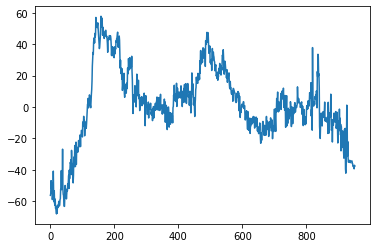

In [53]:

plt.plot(cost_list_reg)
plt.show()

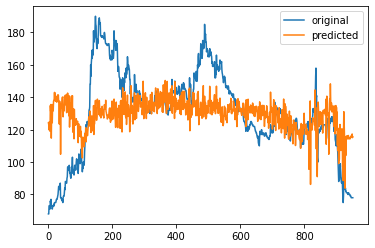

In [54]:
import matplotlib.pyplot as plt
x_ax = range(len(y_pred2_reg))
plt.plot(x_ax, y2, label="original")
plt.plot(x_ax, y_pred2_reg, label="predicted")

plt.legend()
plt.show()

In [26]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [31]:
def model(X,Y,learning_rate,iteration):
    m=Y.size
    theta=np.zeros((9,1))
    cost_list=[]
    
    for i in range (iteration):
        
           y_pred=np.dot(X,theta)
           cost=(1/2*m)*np.sum(np.square(y_pred-Y))
           
           d_theta=(1/m)*np.dot(X.T,y_pred-Y)
           theta=theta-learning_rate*d_theta
        
        
           cost_list.append(cost)
            
    return theta,cost_list
    

In [32]:
iteration=1000
learning_rate=0.0000005
theta,cost_list =model(x_train,y_train,learning_rate=learning_rate,iteration=iteration)

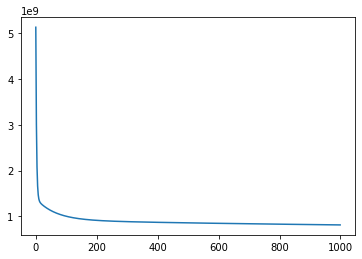

In [33]:
rng=np.arange(0,iteration)
plt.plot(rng,cost_list)
plt.show()

In [425]:
import xgboost
from sklearn.model_selection import learning_curve
train_sizes = [1, 100, 300, 500, 700]


train_sizes, train_scores, validation_scores = learning_curve(
estimator = xgboost.XGBRegressor(reg_lambda=1),
X = df_final2[['stoptime', 
       'p1_meant', 'p1_max', 'prev_trot1_meant', 
        'v1_start', 'v1_end',
         'tamb1_start','duration']],
y = df_final2[['trot1_meant']], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')


In [426]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[-2.09547579e-09 -5.23868948e-10 -5.23868948e-10 -5.23868948e-10
  -5.23868948e-10]
 [-8.73156823e-07 -1.36882474e-06 -1.36882474e-06 -1.36882474e-06
  -1.36882474e-06]
 [-2.49272850e-04 -1.07463954e-04 -2.25652399e-04 -2.25652399e-04
  -2.25652399e-04]
 [-3.00268711e-03 -2.74381685e-03 -2.26572229e-03 -2.05414708e-03
  -2.05414708e-03]
 [-6.57457118e-03 -1.12512857e-02 -8.31784759e-03 -6.83486427e-03
  -6.07990809e-03]]

 ----------------------------------------------------------------------

Validation scores:

 [[-4.50756057e+03 -5.91462128e+03 -7.10903524e+03 -3.12755517e+03
  -2.17929145e+03]
 [-2.27526327e+03 -2.31900553e+03 -3.05807647e+03 -7.38443108e+02
  -4.53078045e+02]
 [-1.27778908e+03 -3.00222680e+01 -2.40262120e+01 -1.38933371e+01
  -1.79237738e+01]
 [-4.84841091e+02 -4.29319612e+00 -2.43060284e+01 -1.27131318e+01
  -1.47608905e+01]
 [-4.12113882e+02 -6.13085452e+00 -1.12814602e+02 -1.01751186e+01
  -1.10809030e+01]]


In [427]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1      8.381903e-10
100    1.269691e-06
300    2.067388e-04
500    2.424104e-03
700    7.811695e-03
dtype: float64

 --------------------

Mean validation scores

 1      4567.612740
100    1768.773282
300     272.730934
500     108.182868
700     110.463072
dtype: float64


(-200.0, 5000.0)

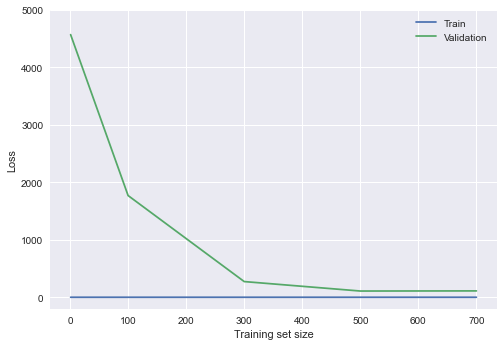

In [428]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Train')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation')
plt.ylabel('Loss')
plt.xlabel('Training set size')
#plt.title('Learning curves for a xg boost regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(-200,5000)

## predicting using xgBoost regressor

In [51]:
import xgboost
regressor=xgboost.XGBRegressor()
eval_set = [(x_train.values, y_train.values), (x_test.values, y_test.values)]
regressor.fit(x_train.values,y_train.values,eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
y_pred2_xg=[]


X2.loc[0,'prev_trot1_meant']= X.loc[0,'prev_trot1_meant']
for i in range(len(X2)):
    
    y_pred_xg=regressor.predict(X2.loc[i,:].to_numpy().reshape(1,-1))
    
    
    X2.loc[i+1,'prev_trot1_meant']= y_pred_xg
    y_pred2_xg.append(y_pred_xg)
    X2.dropna(inplace=True)
 
   
    

C:\Users\zahid\anaconda3\envs\tensorflow-sessions\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\zahid\anaconda3\envs\tensorflow-sessions\lib\site-packages\pandas\core\indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)
C:\Users\zahid\anaconda3\envs\tensorflow-sessions\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to 

In [53]:
cost_list_xg=[]
#m=y_test.size
y2=y2.values.tolist()

for i in range(len(y_pred2_xg)):
    cost_xg=y2[i]-y_pred2_xg[i]
    cost_list_xg.append(cost_xg)

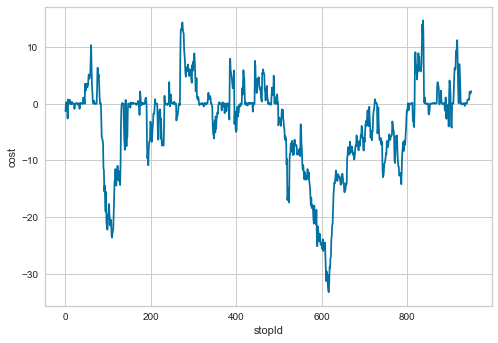

In [54]:
plt.plot(cost_list_xg)
plt.ylabel('cost')
plt.xlabel('stopId')
plt.show()

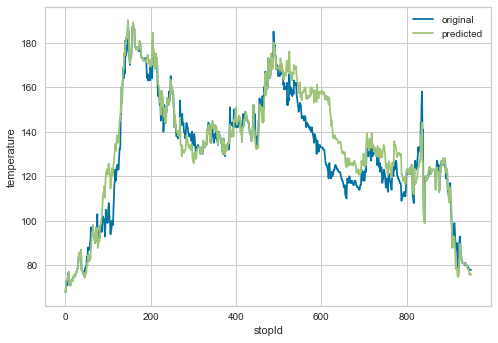

In [55]:
x_ax = range(len(y_pred2_xg))
plt.ylabel('temperature')
plt.xlabel('stopId')
plt.plot(x_ax, y2, label="original")
plt.plot(x_ax, y_pred2_xg, label="predicted")

plt.legend()
plt.show()

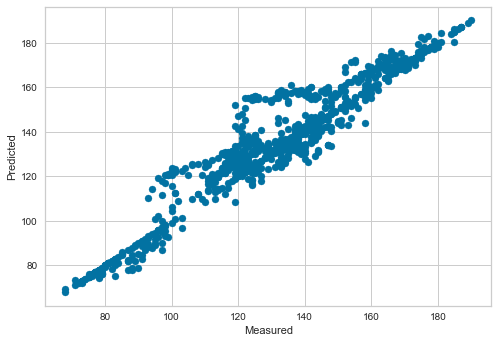

In [56]:
fig, ax = plt.subplots()
ax.scatter(y2, y_pred2_xg)
#ax.plot('k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [48]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

In [57]:
MAE=mae(y2, y_pred2_xg)
MSE = mse(y2, y_pred2_xg)
RMSE = np.sqrt(MSE)

In [58]:
R_squared = r2_score(y2, y_pred2_xg)

In [59]:
print("\nMAE: ", np.round(MAE, 2))
print("\nRMSE: ", np.round(RMSE, 2))
print()
print("R-Squared: ", np.round(R_squared, 2))


MAE:  5.64

RMSE:  8.77

R-Squared:  0.89



Prediction Error Plot


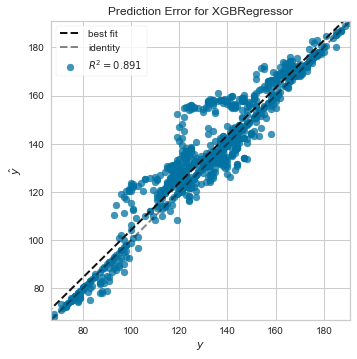

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints='',
                                       learning_rate=0.300000012,
                                       max_delta_step=0, max_depth=6,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=12,
                                       num_parallel_tree=1, random_state=0,
                                       reg_alpha=0, reg_lambda=1,
                                

In [45]:
print("\nPrediction Error Plot")
print(prediction_error(regressor, x_train.values, y_train.values, X2.values, y2.values))

In [31]:
scores = cross_val_score(regressor, x_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.97


## predicting using neural network

In [20]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state = 10)
X_val.reset_index(drop=True, inplace=True)
X2=X[1::]
y2=y[1::]
X.reset_index(drop=True,inplace = True)
X2.reset_index(drop=True,inplace = True)
y2.reset_index(drop=True,inplace = True)


In [204]:
y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)
print(scaler_x.fit(X_val))
xval_scale=scaler_x.transform(X_val)
print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_val))
yval_scale=scaler_y.transform(y_val)
print(scaler_x.fit(X2))
x2_scale=scaler_x.transform(X2)


MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [33]:
model = Sequential()
model.add(Dense(9, input_dim=9, kernel_initializer='normal', activation='relu'))
model.add(Dense(2670, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_4 (Dense)              (None, 2670)              26700     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2671      
Total params: 29,461
Trainable params: 29,461
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=1, validation_split=0.2)
#predictions = model.predict(xval_scale)

Epoch 1/200
4/4 [==============================] - 0s 26ms/step - loss: 16266.2100 - mse: 16266.2100 - mae: 124.3696 - val_loss: 11881.9238 - val_mse: 11881.9238 - val_mae: 105.9899
Epoch 2/200
4/4 [==============================] - 0s 4ms/step - loss: 11226.9629 - mse: 11226.9629 - mae: 101.2874 - val_loss: 7329.7012 - val_mse: 7329.7012 - val_mae: 80.3413
Epoch 3/200
4/4 [==============================] - 0s 4ms/step - loss: 6995.2817 - mse: 6995.2817 - mae: 76.3250 - val_loss: 3941.7571 - val_mse: 3941.7571 - val_mae: 54.2055
Epoch 4/200
4/4 [==============================] - 0s 4ms/step - loss: 4155.5806 - mse: 4155.5806 - mae: 54.8956 - val_loss: 2568.1785 - val_mse: 2568.1785 - val_mae: 44.2280
Epoch 5/200
4/4 [==============================] - 0s 4ms/step - loss: 3504.3752 - mse: 3504.3752 - mae: 49.6259 - val_loss: 3172.4004 - val_mse: 3172.4004 - val_mae: 47.5895
Epoch 6/200
4/4 [==============================] - 0s 5ms/step - loss: 4102.1689 - mse: 4102.1689 - mae: 50.7466 - 

In [35]:
y_pred2=[]


X2.loc[0,'prev_trot1_meant']= X.loc[0,'prev_trot1_meant']
for i in range(len(X2)):
    
    y_pred=model.predict(X2.loc[i,:].to_numpy().reshape(1,-1))
    
    
    X2.loc[i+1,'prev_trot1_meant']= y_pred[0]
    y_pred2.append(y_pred)
    X2.dropna(inplace=True)
 
       

C:\Users\zahid\anaconda3\envs\tensorflow-sessions\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\zahid\anaconda3\envs\tensorflow-sessions\lib\site-packages\pandas\core\indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)
C:\Users\zahid\anaconda3\envs\tensorflow-sessions\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to 

In [36]:
cost_list=[]

y2=y2.values.tolist()

for i in range(len(y_pred2)):
    cost=y2[i]-y_pred2[i]
    cost_list.append(cost)

In [37]:
cost_list2=[]
for i in range (len(cost_list)):
    cost_list2.append(cost_list[i][0][0])




In [38]:
y_pred2_list=[]
for i in range (len(y_pred2)):
    y_pred2_list.append(y_pred2[i][0][0])

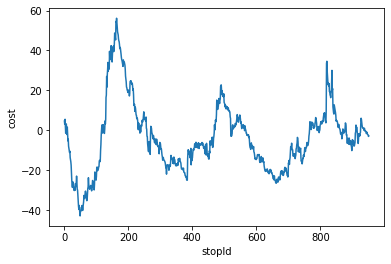

In [39]:
plt.plot(cost_list2)
plt.ylabel('cost')
plt.xlabel('stopId')
plt.show()

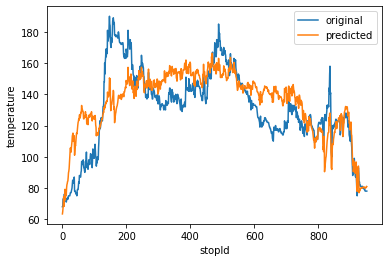

In [40]:
x_ax = range(len(y_pred2))
plt.plot(x_ax, y2, label="original")
plt.plot(x_ax, y_pred2_list, label="predicted")
plt.ylabel('temperature')
plt.xlabel('stopId')
plt.legend()
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


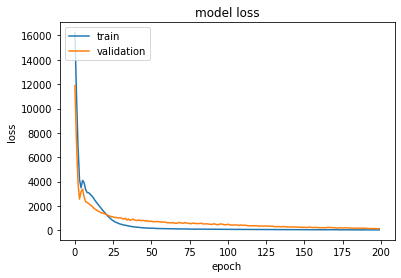

In [41]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

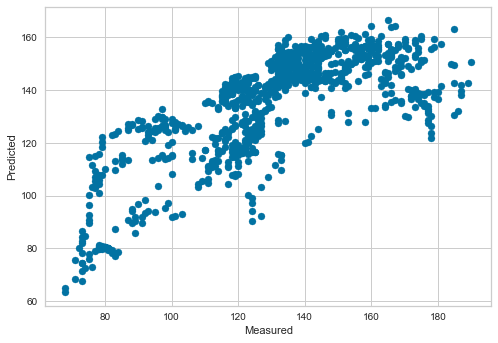

In [47]:
fig, ax = plt.subplots()
ax.scatter(y2, y_pred2_list)
#ax.plot('k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [44]:
R_squared = r2_score(y2, y_pred2_list)

In [45]:
print(R_squared)

0.5488329278089368


In [61]:
MAE=mae(y2, y_pred2_list)
MSE = mse(y2, y_pred2_list)
RMSE = np.sqrt(MSE)
print(RMSE)
print(MAE)

17.87874934923362
13.902809635931705


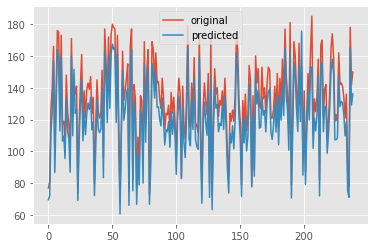

In [185]:
x_ax = range(len(y_val))
plt.plot(x_ax, y_val, label="original")
plt.plot(x_ax, predictions, label="predicted")

plt.legend()
plt.show()